In [40]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [41]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 28*28
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-2
nb_steps  = 100

batch_size = 256

In [42]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [43]:
# Here we load the Dataset
root = os.path.expanduser("~/data/datasets/torch/mnist")
train_dataset = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)

In [44]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=np.int64)
y_test  = np.array(test_dataset.targets, dtype=np.int64)

C:\Users\Joshua\AppData\Local\Temp\ipykernel_16116\1224777063.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = np.array(train_dataset.data, dtype=np.float)
C:\Users\Joshua\AppData\Local\Temp\ipykernel_16116\1224777063.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = np.array(test_dataset.data, dtype=np.float)


(-0.5, 27.5, 27.5, -0.5)

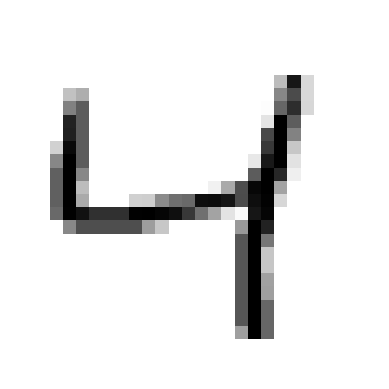

In [45]:
# Here we plot one of the raw data points as an example
data_id = 2
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

In [46]:
x_train.shape

(60000, 784)

Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

In [47]:
def current2firing_time(x, tau=20, thr=0.3, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T

def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out
        
def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int64)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int64)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            
            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

In [48]:
def scale_image(image, scale, time_step):
    scaled_image = image*scale
    for i,prob in enumerate(scaled_image):
        if (prob > 1):
            new_prob = 1
            scaled_image[i] = new_prob
    rate_of_scaled_image = scaled_image/time_step
    average_rate = torch.mean(rate_of_scaled_image)
    return scaled_image, average_rate

In [49]:
def images2spike(x, y, batch_size, shuffle, **kwargs):  
    '''Converts images to spike trains'''
    labels_ = np.array(y,dtype=np.int64)
    number_of_batches = len(x)//batch_size
    sample_index = np.arange(len(x))

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0

    batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
    while counter < number_of_batches:
        x_batch = torch.empty((len(x[batch_index]), nb_steps, nb_inputs)).to(device)
        for i, image in enumerate(x[batch_index]):
            tensor_image = torch.Tensor(image) # probabilities tensor
            zero_image = torch.zeros(tensor_image.shape)
            spike_train = torch.empty((nb_steps, nb_inputs))
            for t in range(nb_steps):
                spike_t = torch.bernoulli(tensor_image)
                spike_train[t] = spike_t
            x_batch[i] = spike_train
        y_batch = torch.tensor(labels_[batch_index],device=device) 

        yield x_batch,  y_batch

        counter += 1

### Setup of the spiking network model

In [50]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [51]:
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.kaiming_normal_(w1, mode = 'fan_in', nonlinearity='sigmoid')

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.kaiming_normal_(w2, mode = 'fan_in', nonlinearity='sigmoid')

print("init done")

init done


In [52]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

## Training the network

In [53]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [54]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    spk_rec2 = []
    for t in range(nb_steps):
        mthr = out-1.0
        output = spike_fn(mthr)
        rst = output.detach() # We do not want to backprop through the reset

        new_flt = alpha*flt +h2[:,t]
        new_out = (beta*out +flt)*(1.0-rst)

        flt = new_flt
        out = new_out

        out_rec.append(out) # membrane potential
        spk_rec2.append(output) # spike train

    out_rec = torch.stack(out_rec,dim=1)
    spk_rec2 = torch.stack(spk_rec2, dim=1)

    return spk_rec2,  spk_rec

In [55]:
def compute_classification_accuracy(x_data, y_data, batch_size, shuffle, **kwargs):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in images2spike(x_data, y_data, batch_size, shuffle=True, **kwargs):
        output, _ = run_snn(x_local)
        spike_count =torch.sum(output,1)
        mean_firing_rate = spike_count/(nb_steps*time_step)
        _, am = torch.max(mean_firing_rate, 1)
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [56]:
def train(x_data, x_test, y_data, y_test,lr=1e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    train_accuracy= []
    test_accuracy = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in images2spike(x_data, y_data, batch_size, shuffle=True):
            output, spks = run_snn(x_local)
            spike_count =torch.sum(output,1)
            mean_firing_rate = spike_count/(nb_steps*time_step)

            log_p_y = log_softmax_fn(mean_firing_rate)
            
            # Here we set up our regularizer loss
            # The strength paramters here are merely a guess and there should be ample room for improvement by
            # tuning these paramters.
            reg_loss = 1e-6*torch.sum(spks) # L1 loss on total number of spikes
            reg_loss += 1e-7*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron

            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) 

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
        train_accuracy.append(compute_classification_accuracy(x_train,y_train, batch_size=256, shuffle=False))
        test_accuracy.append(compute_classification_accuracy(x_test, y_test, batch_size=256, shuffle=False))
        
    return train_accuracy, test_accuracy

In [57]:
train_acc_hist, test_acc_hist = train(x_train, x_test, y_train, y_test, lr=2e-4, nb_epochs=100)

Epoch 1: loss=9.01981
Epoch 2: loss=3.84456
Epoch 3: loss=2.58747
Epoch 4: loss=2.37918
Epoch 5: loss=2.18634
Epoch 6: loss=1.87281
Epoch 7: loss=1.90700
Epoch 8: loss=1.87982
Epoch 9: loss=1.59301
Epoch 10: loss=1.53648
Epoch 11: loss=1.43530
Epoch 12: loss=1.64911
Epoch 13: loss=1.54670
Epoch 14: loss=1.21675
Epoch 15: loss=1.52171
Epoch 16: loss=1.32936
Epoch 17: loss=1.26232
Epoch 18: loss=1.35714
Epoch 19: loss=1.26212
Epoch 20: loss=1.32154
Epoch 21: loss=1.11877
Epoch 22: loss=1.00462
Epoch 23: loss=1.12398
Epoch 24: loss=1.12089
Epoch 25: loss=1.03205
Epoch 26: loss=0.97649
Epoch 27: loss=0.92846
Epoch 28: loss=0.84862
Epoch 29: loss=0.89846
Epoch 30: loss=0.90558
Epoch 31: loss=1.10398
Epoch 32: loss=0.86461
Epoch 33: loss=0.84650
Epoch 34: loss=0.83394
Epoch 35: loss=0.97181
Epoch 36: loss=0.87811
Epoch 37: loss=0.91319
Epoch 38: loss=0.71579
Epoch 39: loss=0.80183
Epoch 40: loss=0.70528
Epoch 41: loss=0.74852
Epoch 42: loss=0.80254
Epoch 43: loss=0.76684
Epoch 44: loss=0.891

53


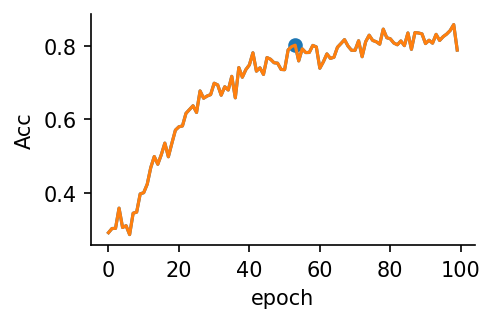

In [66]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(train_acc_hist)
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.plot(train_acc_hist)
for i, acc in enumerate(train_acc_hist):
    if (acc >= 0.80):
        plt.scatter(i, acc,  marker="o", label="points")
        print(i)
        break
sns.despine()
plt.savefig("fan-in-he-initialization-train-accuracy")

51


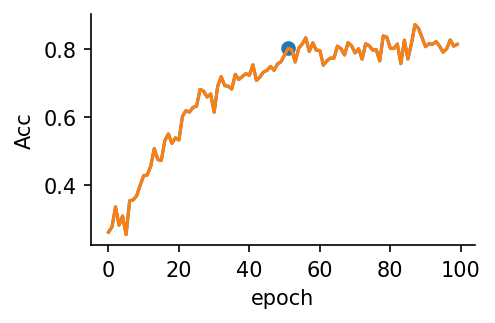

In [67]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(test_acc_hist)
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.plot(test_acc_hist)
for i, acc in enumerate(test_acc_hist):
    if (acc >= 0.80):
        plt.scatter(i, acc,  marker="o", label="points")
        print(i)
        break
sns.despine()
plt.savefig("fan-in-he-initialization-test-accuracy")

In [68]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train, batch_size=256, shuffle=False)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test, batch_size=256, shuffle=False)))

Training accuracy: 0.817
Test accuracy: 0.809


In [69]:
data = {}
data['training_accuracy'] = train_acc_hist
data['test_accuracy'] = test_acc_hist

np.savez("fan-in-He-Initialization.npz".format(train_acc_hist, test_acc_hist),**data)
